RS eredua dugu kasu honetan.

Erabiliko diren moduloak inportatu:

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

Erabiliko diren aldagaien laburbilduma

|Aldagaia|Definizioa|Unitatea|
|--------|-----------|-------|
|$t_{max}$ |Simulazioa denbora maximoa|$ms$|
|$\Delta t$|Denboraren diskretizazioa |$ms$|
|$\tau_{max}$ |Parametro esperimentala|$s$|
|$C_{m}$   |Mintz kapazitatea         |$\frac{\mu F}{cm^{2}}$|
|$E_{Na}$  |Inbertsio potentziala, sodio kanaletarako|$mV$|
|$E_{K}$   |Inbertsio potentziala, potasio kanaletarako|$mV$|
|$E_{L}$   |Inbertsi potentziala|$mV$|
|$g_{Na}$  |Konduktantzia espezifikoa, sodio korronte azkarrerako|$\frac{mS}{cm^{2}}$|
|$g_{K}$   |Konduktantzia espezifikoa, potasio korronte iraukorrerako|$\frac{mS}{cm^{2}}$|
|$g_{M}$   |Konduktantzia espezifikoa, potasio korronte geldorako|$\frac{mS}{cm^{2}}$|
|$g_{L}$   |Konduktantzia espezifikoa|$\frac{mS}{cm^{2}}$|
|$i_{mean}$|Batez-besteko intentsitate bat finkatu|$\frac{\mu A}{cm^{2}}$|
|$V_{rest}$|Egoera egonkorreko mintz potentziala|$mV$|
|$V_{Th}$|Atari potentziala|$mV$|

In [2]:
#Parametroak finkatu#####
t_max=400      # ms
delta_t=0.005   # ms
tau_max=500.0  # ms
C_m=3.14       # micro F/cm^2 (c_m/(L*d)=C_m)
E_Na=50.00     # mV
E_K=-90.00     # mV
E_L=-70.00     # mV
g_Na=50.0      # mS/cm^2
g_K=5.0        # mS/cm^2
g_M=0.07        # mS/cm^2
g_L=0.1        # mS/cm^2
i_mean=6.5     # microA/cm^2
V_rest=-65.0   # mV
v_th=-40.0     # mV
##########################

### Funtzio laguntzaileen inplementazioa

$$\alpha_{m}=\frac{-0.32(v-v_{Th}-13)}{\exp [-(v-v_{Th}-13)/4]-1}$$

$$\beta_{m}=\frac{0.28(v-v_{Th}-40)}{\exp [(v-v_{Th}-40)/5]-1}$$

$$\alpha_{h}=0.128\exp [-(v-v_{Th}-17)/18]$$

$$\beta_{h}=\frac{4}{1+ exp[-(v-v_{Th}-40)/5]}$$

$$\alpha_{n}=\frac{-0.032(v-v_{Th}-15)}{\exp [-(v-v_{Th}-15)/5]-1}$$

$$\beta_{n}=0.5 \exp[-(v-v_{Th}-10)/40]$$

$$p_{\infty}(v)=\frac{1}{1+\exp[-(v+35)/10]}$$

$$\tau_{p}(v)=\frac{\tau_{max}}{3.3\exp[(v+35)/20]+\exp[-(v+35)/20]}$$

In [3]:
def alpha_m(v):
    return -0.32 * (v - v_th - 13.0) / (np.exp(-(v - v_th - 13.0) / 4.0) - 1.0)

def beta_m(v):
    return 0.28 * (v - v_th - 40.0) / (np.exp((v - v_th - 40.0) / 5.0) - 1.0)

def alpha_h(v):
    return 0.128 * np.exp(-(v - v_th - 17.0)/18.0)

def beta_h(v):
    return 4.0 / (1.0 + np.exp(-(v - v_th - 40.0) / 5.0))

def alpha_n(v):
    return -0.032 * (v - v_th - 15.0) / (np.exp(-(v - v_th - 15.0) / 5.0) - 1.0)

def beta_n(v):
    return 0.5 * np.exp(-(v - v_th - 10.0) / 40.0)

def p_infty(v):
    return 1.0 / (1.0 + np.exp(-(v + 35.0) / 10.0))

def tau_p(v):
    return tau_max / (3.3 * np.exp((v + 35.0) / 20.0) + np.exp(-(v + 35.0) / 20.0))

### Bektoreak eta hasierako balioak finkatu

In [4]:
#Denbora eremu osoa finkatzen dugu. 0 s-tik hasiz, delta_t diskretizazio denbora aldiunez t_max aldiunerarte
t_eremua=np.arange(0,t_max,delta_t)
#Luzera finkatu
step=len(t_eremua)

#Vt bektorea finkatu
Vt=np.ones([step])
Vt_0=np.ones([step])
Vt_1=np.ones([step])
Vt_2=np.ones([step])

#Fase espaziorako bektoreaa finkatu
V_dot=np.ones([step])
V_dot_0=np.ones([step])
V_dot_1=np.ones([step])
V_dot_2=np.ones([step])

#nt, mt, ht bektoreak finkatu
nt=np.ones([step])
mt=np.ones([step])
ht=np.ones([step])
pt=np.ones([step])

#Fase espaziorako bektoreak finkatu
n_dot=np.ones([step])
m_dot=np.ones([step])
h_dot=np.ones([step])
p_dot=np.ones([step])

### Gobernu ekuazioen ebazpena

Euler-en aurrerazko formula erabiliz diskretizazioa denboran egiteko:

$$v^{i+1}=v^{i}+\frac{\Delta t}{C_{m}}[I^{i}-\overline{g_{Na}}(m^{3})^{i}h^{i}(v^{i}-E_{Na})-\overline{g_{K}}(n^{4})^{i}(v^{i}-E_{K})-\overline{g_{M}}p^{i}(v^{i}-E_{K})-\overline{g_{L}}(v^{i}-E_{L})]$$

$$n^{i+1}=n^{i}+\Delta t[\alpha_{n}(v^{i})(1-n^{i})-\beta_{n}(v^{i})n^{i}]$$

$$m^{i+1}=m^{i}+\Delta t[\alpha_{m}(v^{i})(1-m^{i})-\beta_{m}(v^{i})m^{i}]$$

$$h^{i+1}=h^{i}+\Delta t[\alpha_{h}(v^{i})(1-h^{i})-\beta_{h}(v^{i})h^{i}]$$

$$p^{i+1}=p^{i}+\Delta t[\frac{p_{\infty}(v^{i})-p^{i}}{\tau_{p}(v^{i})}]$$

Kasu honetan estrategia pixkat desberdina erabiliko da. for batekin RS ereduko gobernu ekuazioetarako 3 ebazpen egingo ditugu. Bakoitzean i_mean + k*1.0 intentsitatea handitzen joango da. Hau hiru bektoreen bidez gordeko da, bai espazio errealean zein fase espazioan. Vt_0,1,2 eta V_dot_1,2,3. Hala ere kode honetan k=1, 2 kasuak bakarrik irudikatuko dira. Izan ere, k=0 kasua 12. Irudian irudikatuko da.

In [5]:
for k in range (0, 3):
    #Hasierako balioak finkatu#
    Vt[0]=V_rest
    nt[0]=alpha_n(V_rest) / (alpha_n(V_rest) + beta_n(V_rest))
    mt[0]=alpha_m(V_rest) / (alpha_m(V_rest) + beta_m(V_rest))
    ht[0]=alpha_h(V_rest) / (alpha_h(V_rest) + beta_h(V_rest))
    pt[0]=p_infty(V_rest)
    I=i_mean + k*1.0
    for i in range(0, step-1) :
        mt[i + 1] = mt[i] + delta_t * (alpha_m(Vt[i]) * (1.0 - mt[i]) - beta_m(Vt[i]) * mt[i])
        ht[i + 1] = ht[i] + delta_t * (alpha_h(Vt[i]) * (1.0 - ht[i]) - beta_h(Vt[i]) * ht[i])
        nt[i + 1] = nt[i] + delta_t * (alpha_n(Vt[i]) * (1.0 - nt[i]) - beta_n(Vt[i]) * nt[i])
        pt[i + 1] = pt[i] + delta_t * ((p_infty(Vt[i]) - pt[i]) / tau_p(Vt[i]))
        Vt[i + 1] = Vt[i] + (delta_t/C_m) * (I-g_Na * mt[i] ** 3 * ht[i] * (Vt[i]-E_Na) - g_K * nt[i] ** 4 * (Vt[i]-E_K)- g_M * pt[i] * (Vt[i] - E_K) - g_L * (Vt[i]-E_L)) 

    #Hasierako egoerak
    V_dot[0]= (Vt[1] - Vt[0]) / delta_t 
    n_dot[0]= (nt[1] - nt[0]) / delta_t
    m_dot[0]= (mt[1] - mt[0]) / delta_t
    h_dot[0]= (ht[1] - ht[0]) / delta_t
    p_dot[0]= (pt[1] - pt[0]) / delta_t

    #Gainontzeko aldiuneak
    for i in range (0,step-1):
        V_dot[i+1]= (Vt[i+1] - Vt[i]) / delta_t
        n_dot[i+1]= (nt[i+1] - nt[i]) / delta_t
        m_dot[i+1]= (mt[i+1] - mt[i]) / delta_t
        h_dot[i+1]= (ht[i+1] - ht[i]) / delta_t
        p_dot[i+1]= (pt[i+1] - pt[i]) / delta_t
    
    #Lehenengo intentsitaterako informazio gorde
    if k==0:
        for i in range (0,step):
            V_dot_0[i]=V_dot[i]
            Vt_0[i]=Vt[i]
            
    #Bigarrengo intentsitaterako informazio gorde    
    if k==1:
        for i in range(0,step):
            V_dot_1[i]=V_dot[i]
            Vt_1[i]=Vt[i]
            
    #Hirugarrengo intentsitaterako informazio gorde      
    if k==2:
        for i in range(0,step):
            V_dot_2[i]=V_dot[i]
            Vt_2[i]=Vt[i]

Ploteatu

<Figure size 432x288 with 0 Axes>

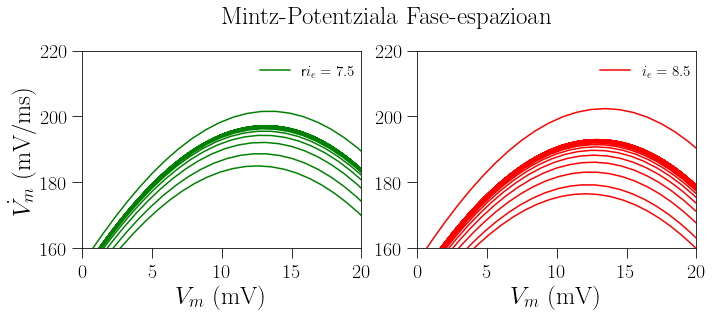

In [6]:
#################################  ### 00 ###

plt.rc('text', usetex=True)

#################################

fig = plt.figure()

#################################  ### 01 ###
fontsize = 25
labelsize = 20
#################################

fig, ax2 = plt.subplots(figsize=(11, 8))
ax2 = plt.subplot(221)
ax2.set_xlim(0,20)
ax2.set_ylim(160,220)
ax2.plot(Vt_1, V_dot_1, 'g', label='r$i_{e}=7.5$')
ax2.set_xlabel(r'$V_{m} \textrm{ (mV)}$',fontsize=fontsize)
ax2.set_ylabel(r'$\dot{V_{m}} \textrm{ (mV/ms)}$',fontsize=fontsize)
ax2.legend(bbox_transform=ax2.transData, bbox_to_anchor=(20, 218), ncol=1, borderaxespad=0, 
             frameon=False, fontsize=15)

fig.text(10, 230.0, r'\textrm{Mintz-Potentziala Fase-espazioan}', size=25, va='center', transform=ax2.transData);


ax3 = plt.subplot(222)
ax3.set_xlim(0,20)
ax3.set_ylim(160,220)
ax3.plot(Vt_2, V_dot_2, 'r',label=r'$i_{e}=8.5$')
ax3.set_xlabel(r'$V_{m}\textrm{ (mV)}$',fontsize=fontsize)
ax3.legend(bbox_transform=ax3.transData, bbox_to_anchor=(20, 218), ncol=1, borderaxespad=0, 
             frameon=False, fontsize=15)

######################################  ### 04 ###
axes_fig = [ax2,ax3] # irudiak dazkanaren arabera

for i in axes_fig:
    i.tick_params(axis='y', labelsize=labelsize, pad=5, length=10);
    i.tick_params(axis='x', labelsize=labelsize, pad=5, length=10);

plt.savefig('RS_Eredua_Fase_Espazioa_2.pdf', format='pdf', dpi=180,bbox_inches="tight")